In [1]:
import torch
import os
import json
import tqdm
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection

In [2]:
fnames = os.listdir("data")
fields = ['name','smiles','notes']
molecules = []
for fname in tqdm.tqdm(fnames):
    with open(os.path.join("data",fname)) as f:
        mol = json.load(f)
        data = {k:mol[k] for k in fields}
        # Check that the molecule has all the fields of interest
        if all(data.values()):
            molecules.append(data)

# Have to de-dupe the notes for each molecule.
for mol in molecules:
    mol["notes"] = set(mol["notes"])
    
print(f"Found {len(molecules)} molecules.")
molecules[:3]

100%|███████████████████████████████████| 19194/19194 [00:02<00:00, 6866.01it/s]

Found 3440 molecules.


[{'name': 'amyl butyrate',
  'smiles': 'CCCCCOC(=O)CCC',
  'notes': {'banana', 'cherry', 'fruity', 'pineapple', 'sweet', 'tropical'}},
 {'name': 'para-anisyl phenyl acetate',
  'smiles': 'COC1=CC=C(C=C1)COC(=O)CC2=CC=CC=C2',
  'notes': {'anise', 'balsamic', 'honey', 'woody'}},
 {'name': 'dihydrofarnesol',
  'smiles': 'CC(CC/C=C(\\C)/CCC=C(C)C)CCO',
  'notes': {'cyclamen', 'floral', 'metallic'}}]

In [3]:
all_notes = collections.Counter()
for mol in molecules:
    all_notes.update(mol["notes"])
print(f"Found {len(all_notes)} unique notes.")
print("Most common:")
print(all_notes.most_common(5))

Found 502 unique notes.
Most common:
[('fruity', 1060), ('green', 967), ('sweet', 884), ('floral', 706), ('woody', 558)]


In [4]:
all_notes_list = list(all_notes.keys())

def multi_hot(notes):
    indices = torch.tensor([all_notes_list.index(n) for n in notes])
    if len(indices) == 0:
        # Occurs when the notes in the pair were removed due to infrequency.
        raise AttributeError("Found no valid notes.")
    one_hots = torch.nn.functional.one_hot(indices, len(all_notes))
    return one_hots.sum(dim=0).float()

for mol in molecules:
    mol["encoding"] = multi_hot(mol["notes"])

print(molecules[0])

{'name': 'amyl butyrate', 'smiles': 'CCCCCOC(=O)CCC', 'notes': {'cherry', 'fruity', 'tropical', 'sweet', 'banana', 'pineapple'}, 'encoding': tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [5]:
SOM = collections.namedtuple("SOM",["vectors","idxs"])

def make_som(width,height):
    somap = torch.rand((width,height,len(all_notes)))

    map_x_idx, map_y_idx = torch.meshgrid(torch.arange(start=0,end=width), torch.arange(start=0,end=height), indexing='ij')
    map_idx = torch.stack([map_x_idx,map_y_idx],dim=-1)

    return SOM(somap,map_idx)


In [6]:
def get_activations(som,encoding):
    return torch.nn.functional.cosine_similarity(encoding, som.vectors, dim=-1)
    
def get_bmu(som,encoding):
    actvtn = get_activations(som,encoding)
    bmu_idx = (actvtn==torch.max(actvtn)).nonzero()
    return bmu_idx[0]

def get_score(som,encoding):
    actvtn = get_activations(som,encoding)
    return torch.max(actvtn)

def get_distances_manhattan(som,bmu):
    xy_dist = som.idxs - bmu
    return torch.sum(torch.abs(xy_dist),dim=-1)

def get_distances(som,bmu):
    xy_dist = som.idxs - bmu
    return torch.sqrt(torch.sum(torch.square(xy_dist),dim=-1))

def update_factor(som,bmu):
    dists = get_distances(som,bmu)
    return torch.pow(1/2,dists)

def get_deltas(som,encoding):
    return encoding-som.vectors

def update_som(som,encoding,lr):
    bmu = get_bmu(som,encoding)
    uf = update_factor(som,bmu)
    deltas = get_deltas(som,encoding)
    return SOM(som.vectors + lr*uf.unsqueeze(-1)*deltas, som.idxs)

mm = make_som(3,2)
e0 = molecules[0]["encoding"]
bmu0 = get_bmu(mm,e0)
# When we do the update with lr=1, we expect the bmu to updated to the encoding
mp0 = update_som(mm,e0,1)
assert torch.all(mp0.vectors[bmu0[0],bmu0[1]] == e0)

In [7]:
def flatten(mtrx):
    return mtrx.reshape((mtrx.shape[0]*mtrx.shape[1],-1)).squeeze()

def clean_activations(activations,thresh):
    flact = flatten(activations)
    return torch.nn.functional.threshold(flact,thresh,0)

def plot(note):
    act = clean_activations(get_activations(som,multi_hot([note])),.1)
    plt.scatter(pos[:,0],pos[:,1],s=act.numpy())


In [16]:
som = make_som(25*4,20*4)
pos = flatten(som.idxs).numpy()

In [90]:
def plot(activations,bmu,as_size,factor=1):
    plt.clf()
    act = flatten(activations)
    minv, maxv = act.min().numpy(), act.max().numpy()
    if as_size:
        # For very very small values, matplotlib will underflow and draw circles where it should draw nothing.
        act = torch.nn.functional.threshold(act,1e-5,0)
        plt.scatter(pos[:,0],pos[:,1],s=factor*act.numpy())
    else:
        plt.scatter(pos[:,0],pos[:,1],c=factor*act.numpy())
        plt.set_cmap('PiYG_r')
        plt.colorbar()
        # cbar.lim(minv,maxv)
        
    plt.title(f"BMU of {bmu.numpy()} w/ value = {activations[bmu[0],bmu[1]]}. Range = ({minv:.2f}, {maxv:.2f})")
    plt.show()

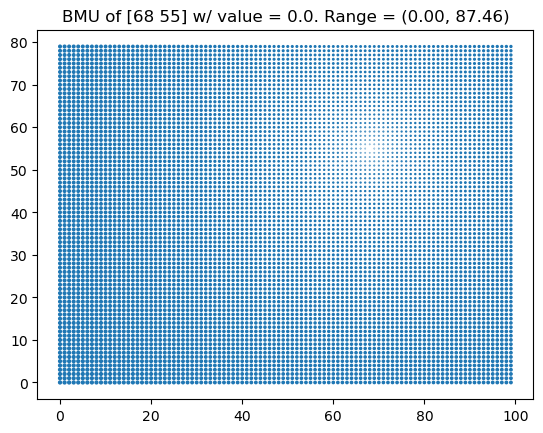

In [17]:
bmu_ex = get_bmu(som,multi_hot(["musk"]))
ds = get_distances(som,bmu_ex)
plot(ds,bmu_ex,True,factor=5e-2)

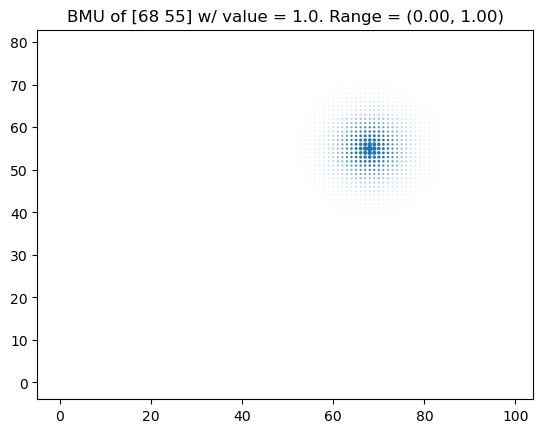

In [18]:
uf = update_factor(som,bmu_ex)
plot(uf,bmu_ex,True,factor=1e1)

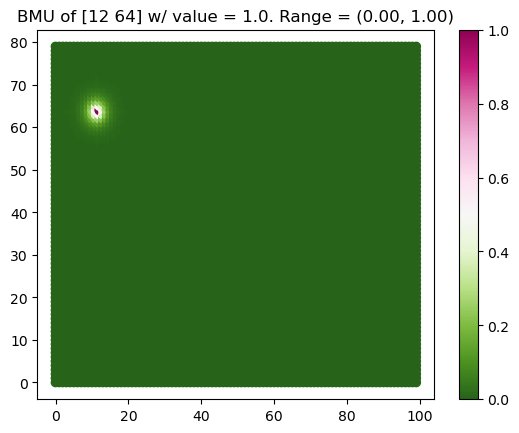

In [102]:
uf = update_factor(som,bmu_ex)
uf = uf 
# uf = 
plot(uf,bmu_ex,False)

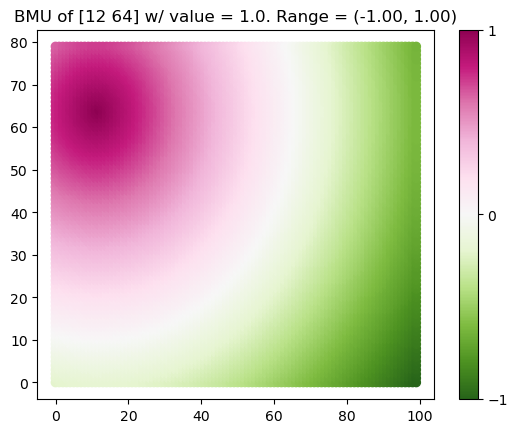

In [84]:
bmu_ex = get_bmu(som,multi_hot(["honey"]))
ds = get_distances(som,bmu_ex)
ds = 1-2*(ds/ds.max())
plot(ds,bmu_ex,False)

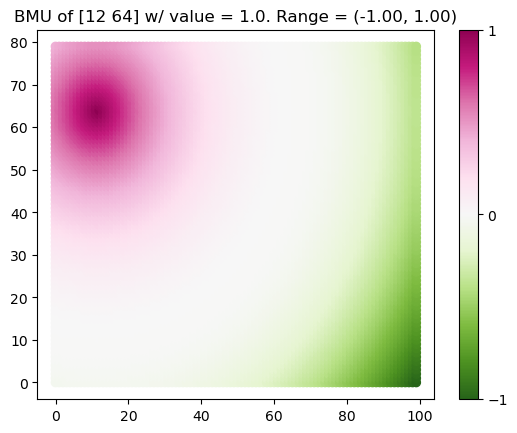

In [85]:
bmu_ex = get_bmu(som,multi_hot(["honey"]))
ds = get_distances(som,bmu_ex)
ds = 1-2*(ds/ds.max())
ds = ds.square()*ds.sign()
plot(ds,bmu_ex,False)

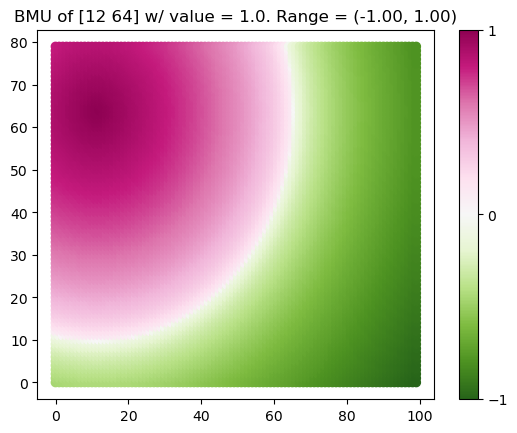

In [87]:
bmu_ex = get_bmu(som,multi_hot(["honey"]))
ds = get_distances(som,bmu_ex)
ds = 1-2*(ds/ds.max())
ds = ds.abs().sqrt()*ds.sign()
plot(ds,bmu_ex,False)

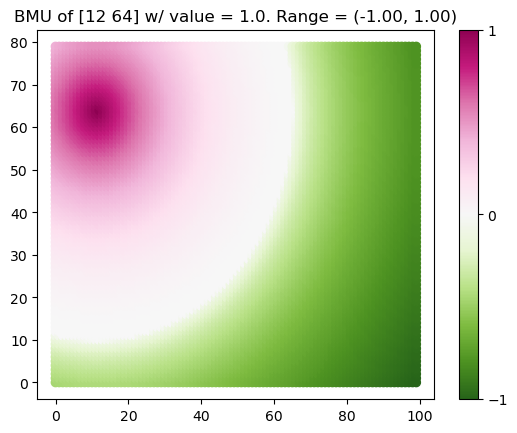

In [82]:
bmu_ex = get_bmu(som,multi_hot(["honey"]))
ds = get_distances(som,bmu_ex)
# ds = ds
ds = 1-2*(ds/ds.max())
ds = torch.where(ds > 0, ds.square(), ds.abs().sqrt()*ds.sign())
plot(ds,bmu_ex,False)

tensor([68, 55])


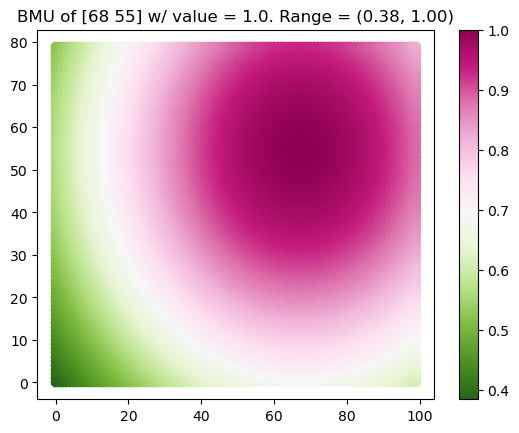

In [132]:
bmu_ex = get_bmu(som,multi_hot(["musk"]))
print(bmu_ex)
ds = get_distances(som,bmu_ex)
w = som.vectors.shape[0]*som.vectors.shape[1]
ds = torch.exp(torch.neg(torch.div(ds.square(), w)))
plot(ds,bmu_ex,False)

tensor([68, 55])


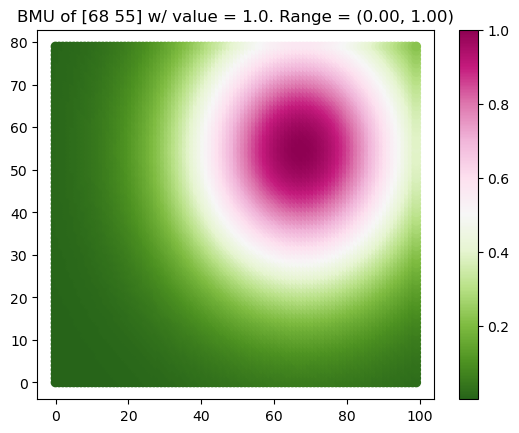

In [135]:
bmu_ex = get_bmu(som,multi_hot(["musk"]))
print(bmu_ex)
ds = get_distances(som,bmu_ex)
w = 10
ds = torch.exp(torch.neg(torch.div(ds.square(), 2**w)))
plot(ds,bmu_ex,False)